In [1]:
import os
import re
import time
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

In [2]:
import cellregmap 
cellregmap 

<module 'cellregmap' from '/hps/nobackup/stegle/users/acuomo/git_repos/CellRegMap/cellregmap/__init__.py'>

In [3]:
from cellregmap import run_interaction

In [4]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [7]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [8]:
############################################
################ Kinship matrix ############
############################################

In [9]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [10]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [11]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [12]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [13]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [14]:
############################################
##### expand from donors to cells ##########

In [18]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [19]:
######################################
############### Genotypes ############
######################################

In [20]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)


Mapping files: 100%|██████████| 3/3 [06:02<00:00, 120.94s/it]


In [21]:
######################################
########## Cell contexts #############
######################################

In [22]:
# cells by PCs (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/20PCs.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [23]:
# quantile normalise cell contexts
C1 = C
C1_gauss = quantile_gaussianize(C1)

In [24]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [25]:
# quantile normalise cell contexts
C2 = C
C2_gauss = quantile_gaussianize(C2)

In [26]:
import matplotlib.pyplot as plt

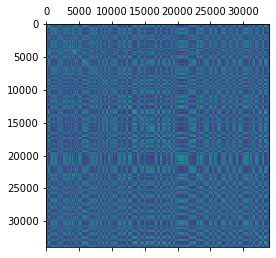

In [27]:
plt.matshow(C1.values @ C1.values.T)

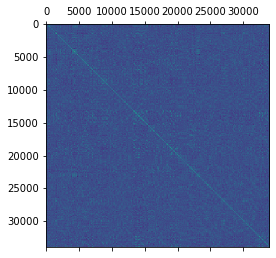

In [26]:
plt.matshow(C2.values @ C2.values.T)

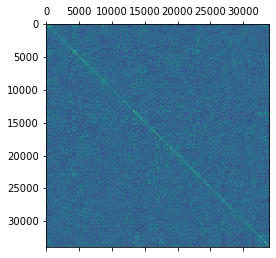

In [27]:
plt.matshow(C1_gauss.values @ C1_gauss.values.T)

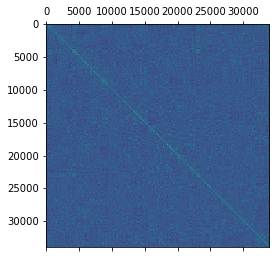

In [28]:
plt.matshow(C2_gauss.values @ C2_gauss.values.T)

In [21]:
#####################################
############ Phenotypes #############
#####################################

In [28]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [29]:
#####################################
############ Filter file ############
#####################################

In [30]:
# filter file (columns: snp_id, gene)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
endo_eqtl.head(2)

,snp_id,feature,stage,chrom
0,5_149826526_C_T,ENSG00000164587_RPS14,ips,5
1,11_57283988_C_T,ENSG00000134809_TIMM10,ips,11


In [31]:
chrom = 22
# and consider eGenes on that chromosome
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [32]:
len(genes)

88

In [33]:
outdir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_int_PCA/"

In [34]:
genes

array(['ENSG00000100058_CRYBB2P1', 'ENSG00000184674_GSTT1',
       'ENSG00000196236_XPNPEP3', 'ENSG00000189306_RRP7A',
       'ENSG00000100410_PHF5A', 'ENSG00000093072_CECR1',
       'ENSG00000099974_DDTL', 'ENSG00000100033_PRODH',
       'ENSG00000179750_APOBEC3B', 'ENSG00000099984_GSTT2',
       'ENSG00000100429_HDAC10', 'ENSG00000100122_CRYBB1',
       'ENSG00000133433_GSTT2B', 'ENSG00000128283_CDC42EP1',
       'ENSG00000099942_CRKL', 'ENSG00000215012_C22orf29',
       'ENSG00000100422_CERK', 'ENSG00000100376_FAM118A',
       'ENSG00000099940_SNAP29', 'ENSG00000100417_PMM1',
       'ENSG00000075234_TTC38', 'ENSG00000211643_IGLV5-52',
       'ENSG00000099977_DDT', 'ENSG00000128191_DGCR8',
       'ENSG00000100413_POLR3H', 'ENSG00000185339_TCN2',
       'ENSG00000128294_TPST2', 'ENSG00000185838_GNB1L',
       'ENSG00000184983_NDUFA6', 'ENSG00000185651_UBE2L3',
       'ENSG00000100243_CYB5R3', 'ENSG00000169314_C22orf15',
       'ENSG00000244509_APOBEC3C', 'ENSG00000100347_SAMM50',
    

In [119]:
gene_name = genes[21]
gene_name

'ENSG00000211643_IGLV5-52'

In [126]:
trait_name = re.sub("_.*","",gene_name)
trait_name

'ENSG00000211643'

In [121]:
leads = endo_eqtl[endo_eqtl['feature']==gene_name]['snp_id'].unique()
G_sel = G[:,G['snp'].isin(leads)]
G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)
#     trait_name = re.sub("-",".",trait_name)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


In [122]:
y = phenotype.sel(trait=gene_name)
y = quantile_gaussianize(y)
y = y.values.reshape(y.shape[0],1)
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))
GG = G_expanded.values

In [ ]:
# to plot in R

## MOFA (pv2)
x = c(8.465845e-10,  2.912894e-02, 3.468064e-10,  0.005462, 0.348159, 0.092094, 0.018068, 0.202231, 0.375638, 0.720105, 0.471773, 
     3.969373e-13, 5.576247e-13, 0.208862, 0.656033, 0.353284, 0.006725, 0.888190, 0.000003, 0.011491, 1.328878e-11, 6.727592e-12,
     0.436182, 0.686520, 2.398976e-17,  1.300539e-11, 3.080535e-10, 3.930914e-09, 0.318595, 0.057419, 0.011458, 0.914385, 0.971026, 0.057087,
     0.038254, 0.000005, 0.419376, 0.145234, 0.25096)
## PCA same settings (pv1)
y0 = c(3.925165e-08, 1.479959e-01, 0.000002, 0.000013, 0.506967, 0.623026, 0.573080, 0.617558, 0.010549, 0.063797,  0.737298, 
      4.305688e-08, 4.265852e-08,  0.496111, 0.113183, 0.770560, 0.006461, 0.843212, 0.000083, 0.790454, 0.371885, 0.000005,
      0.002163, 0.000973, 0.002189, 2.790155e-01, 1.607384e-05, 7.375778e-07, 0.167699, 0.076387, 0.016253, 0.151978, 0.399287, 0.000248,
      0.060604, 0.001412, 0.027694, 3.246701e-13, 0.235666)
## PCA new settings (pv3)
y1 = c(2.621800e-09, 1.523839e-01, 7.361991e-07, 0.000091,  0.150256, 0.208150, 0.071290,  0.103972, 0.594653, 0.873261, 0.880462, 
    5.975197e-11, 6.204527e-11, 0.073163, 0.522266, 0.157959, 0.000009, 0.771356,  0.000026, 0.015247, 0.000002,  0.000001,
      0.068251, 0.344028, 1.544407e-11, 5.245872e-07, 7.264206e-06, 1.030548e-07, 0.032324, 0.660564, 0.026923, 0.761398, 0.941789, 0.027940,
      0.138652, 0.000231, 0.123492, 0.212339, 0.099479)

In [ ]:
### ENSG00000211643_IGLV5-52

In [127]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 3/3 [17:14<00:00, 344.92s/it]


,chrom,pv,variant
0,22,0.000897,22_22645490_G_A
1,22,0.000025,22_22661150_T_C
2,22,0.000079,22_22663216_A_G


In [128]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 3/3 [16:06<00:00, 322.12s/it]


,chrom,pv,variant
0,22,0.051724,22_22645490_G_A
1,22,0.004639,22_22661150_T_C
2,22,0.012965,22_22663216_A_G


In [129]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 3/3 [08:46<00:00, 175.61s/it]


,chrom,pv,variant
0,22,0.039506,22_22645490_G_A
1,22,0.015140,22_22661150_T_C
2,22,0.031601,22_22663216_A_G


In [ ]:
### ENSG00000075234_TTC38

In [116]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [05:35<00:00, 335.41s/it]


,chrom,pv,variant
0,22,0.235666,22_46719054_T_C


In [117]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [05:31<00:00, 331.38s/it]


,chrom,pv,variant
0,22,0.25096,22_46719054_T_C


In [118]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:52<00:00, 172.54s/it]


,chrom,pv,variant
0,22,0.099479,22_46719054_T_C


In [ ]:
### ENSG00000100417_PMM1

In [109]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [05:22<00:00, 322.36s/it]


,chrom,pv,variant
0,22,3.246701e-13,22_41877989_A_G


In [110]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [05:14<00:00, 314.45s/it]


,chrom,pv,variant
0,22,0.145234,22_41877989_A_G


In [111]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:58<00:00, 178.70s/it]


,chrom,pv,variant
0,22,0.212339,22_41877989_A_G


In [ ]:
### ENSG00000099940_SNAP29

In [101]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [05:10<00:00, 310.45s/it]


,chrom,pv,variant
0,22,0.027694,22_21113793_G_A


In [102]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [05:07<00:00, 307.26s/it]


,chrom,pv,variant
0,22,0.419376,22_21113793_G_A


In [103]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:48<00:00, 168.76s/it]


,chrom,pv,variant
0,22,0.123492,22_21113793_G_A


In [ ]:
### ENSG00000100376_FAM118A

In [94]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 2/2 [10:15<00:00, 307.91s/it]


,chrom,pv,variant
0,22,0.060604,22_45714489_T_C
1,22,0.001412,22_45789743_T_G


In [95]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 2/2 [09:57<00:00, 298.53s/it]


,chrom,pv,variant
0,22,0.038254,22_45714489_T_C
1,22,0.000005,22_45789743_T_G


In [96]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 2/2 [05:29<00:00, 164.93s/it]


,chrom,pv,variant
0,22,0.138652,22_45714489_T_C
1,22,0.000231,22_45789743_T_G


In [ ]:
### ENSG00000100422_CERK

In [87]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 3/3 [15:30<00:00, 310.20s/it]


,chrom,pv,variant
0,22,0.151978,22_47066294_T_C
1,22,0.399287,22_47076718_T_G
2,22,0.000248,22_47124827_A_C


In [88]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 3/3 [15:18<00:00, 306.13s/it]


,chrom,pv,variant
0,22,0.914385,22_47066294_T_C
1,22,0.971026,22_47076718_T_G
2,22,0.057087,22_47124827_A_C


In [89]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 3/3 [08:09<00:00, 163.14s/it]


,chrom,pv,variant
0,22,0.761398,22_47066294_T_C
1,22,0.941789,22_47076718_T_G
2,22,0.027940,22_47124827_A_C


In [ ]:
### ENSG00000215012_C22orf29

In [80]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [05:03<00:00, 303.16s/it]


,chrom,pv,variant
0,22,0.016253,22_19833781_G_A


In [81]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [04:59<00:00, 299.47s/it]


,chrom,pv,variant
0,22,0.011458,22_19833781_G_A


In [82]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:46<00:00, 166.79s/it]


,chrom,pv,variant
0,22,0.026923,22_19833781_G_A


In [ ]:
### ENSG00000099942_CRKL

In [73]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [04:37<00:00, 277.18s/it]


,chrom,pv,variant
0,22,0.076387,22_21309934_C_G


In [74]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [04:26<00:00, 266.45s/it]


,chrom,pv,variant
0,22,0.057419,22_21309934_C_G


In [75]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:23<00:00, 143.62s/it]


,chrom,pv,variant
0,22,0.660564,22_21309934_C_G


In [ ]:
### ENSG00000128283_CDC42EP1

In [66]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [04:43<00:00, 283.31s/it]


,chrom,pv,variant
0,22,0.167699,22_37949661_A_T


In [67]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [04:34<00:00, 274.03s/it]


,chrom,pv,variant
0,22,0.318595,22_37949661_A_T


In [68]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:38<00:00, 158.39s/it]


,chrom,pv,variant
0,22,0.032324,22_37949661_A_T


In [ ]:
### ENSG00000133433_GSTT2B

In [59]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 3/3 [13:52<00:00, 277.59s/it]


,chrom,pv,variant
0,22,2.790155e-01,22_24314006_G_T
1,22,1.607384e-05,22_24323514_C_T
2,22,7.375778e-07,22_24335228_A_C


In [60]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 3/3 [13:57<00:00, 279.31s/it]


,chrom,pv,variant
0,22,1.300539e-11,22_24314006_G_T
1,22,3.080535e-10,22_24323514_C_T
2,22,3.930914e-09,22_24335228_A_C


In [61]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 3/3 [07:25<00:00, 148.66s/it]


,chrom,pv,variant
0,22,5.245872e-07,22_24314006_G_T
1,22,7.264206e-06,22_24323514_C_T
2,22,1.030548e-07,22_24335228_A_C


In [ ]:
### ENSG00000100122_CRYBB1

In [52]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 1/1 [04:49<00:00, 289.06s/it]


,chrom,pv,variant
0,22,0.002189,22_26996946_G_A


In [53]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 1/1 [05:01<00:00, 301.96s/it]


,chrom,pv,variant
0,22,2.398976e-17,22_26996946_G_A


In [54]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 1/1 [02:32<00:00, 152.92s/it]


,chrom,pv,variant
0,22,1.544407e-11,22_26996946_G_A


In [ ]:
### ENSG00000100429_HDAC10

In [45]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()


100%|██████████| 2/2 [10:41<00:00, 320.51s/it]


,chrom,pv,variant
0,22,0.002163,22_50674232_G_A
1,22,0.000973,22_50676459_A_G


In [46]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 2/2 [10:22<00:00, 311.47s/it]


,chrom,pv,variant
0,22,0.436182,22_50674232_G_A
1,22,0.686520,22_50676459_A_G


In [47]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 2/2 [05:33<00:00, 166.58s/it]


,chrom,pv,variant
0,22,0.068251,22_50674232_G_A
1,22,0.344028,22_50676459_A_G


In [ ]:
### ENSG00000099984_GSTT2

In [148]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [11:02<00:00, 331.41s/it]


,chrom,pv,variant
0,22,0.371885,22_24255296_C_T
1,22,0.000005,22_24323514_C_T


In [39]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()


100%|██████████| 2/2 [09:12<00:00, 276.19s/it]


,chrom,pv,variant
0,22,1.328878e-11,22_24255296_C_T
1,22,6.727592e-12,22_24323514_C_T


In [40]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()


100%|██████████| 2/2 [05:07<00:00, 153.71s/it]


,chrom,pv,variant
0,22,0.000002,22_24255296_C_T
1,22,0.000001,22_24323514_C_T


In [ ]:
### ENSG00000179750_APOBEC3B

In [105]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [11:54<00:00, 357.37s/it]


,chrom,pv,variant
0,22,0.000083,22_39358037_A_C
1,22,0.790454,22_39383918_G_A


In [106]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:58<00:00, 329.00s/it]


,chrom,pv,variant
0,22,0.000003,22_39358037_A_C
1,22,0.011491,22_39383918_G_A


In [107]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [06:27<00:00, 193.64s/it]


,chrom,pv,variant
0,22,0.000026,22_39358037_A_C
1,22,0.015247,22_39383918_G_A


In [ ]:
### ENSG00000100033_PRODH

In [96]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [09:38<00:00, 289.33s/it]


,chrom,pv,variant
0,22,0.006461,22_18909505_T_C
1,22,0.843212,22_18915282_C_T


In [99]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [09:56<00:00, 298.12s/it]


,chrom,pv,variant
0,22,0.006725,22_18909505_T_C
1,22,0.888190,22_18915282_C_T


In [100]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [06:03<00:00, 181.97s/it]


,chrom,pv,variant
0,22,0.000009,22_18909505_T_C
1,22,0.771356,22_18915282_C_T


In [88]:
### ENSG00000099974_DDTL

In [89]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [17:06<00:00, 342.27s/it]


,chrom,pv,variant
0,22,0.496111,22_24302194_G_A
1,22,0.113183,22_24323878_G_A
2,22,0.770560,22_24333977_G_C


In [90]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 3/3 [16:23<00:00, 327.80s/it]


,chrom,pv,variant
0,22,0.208862,22_24302194_G_A
1,22,0.656033,22_24323878_G_A
2,22,0.353284,22_24333977_G_C


In [91]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [09:02<00:00, 180.98s/it]


,chrom,pv,variant
0,22,0.073163,22_24302194_G_A
1,22,0.522266,22_24323878_G_A
2,22,0.157959,22_24333977_G_C


In [ ]:
### ENSG00000093072_CECR1

In [81]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [11:15<00:00, 337.85s/it]


,chrom,pv,variant
0,22,4.305688e-08,22_17680519_A_C
1,22,4.265852e-08,22_17685194_T_A


In [82]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:56<00:00, 328.27s/it]


,chrom,pv,variant
0,22,3.969373e-13,22_17680519_A_C
1,22,5.576247e-13,22_17685194_T_A


In [83]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:42<00:00, 171.04s/it]


,chrom,pv,variant
0,22,5.975197e-11,22_17680519_A_C
1,22,6.204527e-11,22_17685194_T_A


In [ ]:
### ENSG00000100410_PHF5A

In [73]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [15:12<00:00, 304.17s/it]


,chrom,pv,variant
0,22,0.010549,22_41806768_C_G
1,22,0.063797,22_41854446_C_T
2,22,0.737298,22_41925535_T_C


In [74]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 3/3 [16:23<00:00, 327.85s/it]


,chrom,pv,variant
0,22,0.375638,22_41806768_C_G
1,22,0.720105,22_41854446_C_T
2,22,0.471773,22_41925535_T_C


In [76]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [09:05<00:00, 181.95s/it]


,chrom,pv,variant
0,22,0.594653,22_41806768_C_G
1,22,0.873261,22_41854446_C_T
2,22,0.880462,22_41925535_T_C


In [ ]:
### ENSG00000189306_RRP7A

In [65]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [15:50<00:00, 316.84s/it]


,chrom,pv,variant
0,22,0.623026,22_42896474_T_C
1,22,0.573080,22_42897414_A_C
2,22,0.617558,22_42903671_T_G


In [66]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 3/3 [15:06<00:00, 302.25s/it]


,chrom,pv,variant
0,22,0.092094,22_42896474_T_C
1,22,0.018068,22_42897414_A_C
2,22,0.202231,22_42903671_T_G


In [68]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [08:36<00:00, 172.29s/it]


,chrom,pv,variant
0,22,0.208150,22_42896474_T_C
1,22,0.071290,22_42897414_A_C
2,22,0.103972,22_42903671_T_G


In [52]:
### ENSG00000196236_XPNPEP3

In [55]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [11:27<00:00, 343.52s/it]


,chrom,pv,variant
0,22,0.000013,22_41256802_A_G
1,22,0.506967,22_41394128_C_T


In [53]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [11:39<00:00, 349.94s/it]


,chrom,pv,variant
0,22,0.005462,22_41256802_A_G
1,22,0.348159,22_41394128_C_T


In [54]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:50<00:00, 175.35s/it]


,chrom,pv,variant
0,22,0.000091,22_41256802_A_G
1,22,0.150256,22_41394128_C_T


In [45]:
### ENSG00000184674_GSTT1

In [60]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [05:46<00:00, 346.94s/it]


,chrom,pv,variant
0,22,0.000002,22_24295427_C_T


In [46]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:52<00:00, 292.59s/it]


,chrom,pv,variant
0,22,3.468064e-10,22_24295427_C_T


In [47]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:54<00:00, 174.45s/it]


,chrom,pv,variant
0,22,7.361991e-07,22_24295427_C_T


In [ ]:
### ENSG00000100058_CRYBB2P1

In [40]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [11:39<00:00, 349.67s/it]


,chrom,pv,variant
0,22,3.925165e-08,22_25845855_C_G
1,22,1.479959e-01,22_25924999_G_A


In [34]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:21<00:00, 310.71s/it]


,chrom,pv,variant
0,22,8.465845e-10,22_25845855_C_G
1,22,2.912894e-02,22_25924999_G_A


In [40]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:46<00:00, 173.32s/it]


,chrom,pv,variant
0,22,2.621800e-09,22_25845855_C_G
1,22,1.523839e-01,22_25924999_G_A


In [29]:
for gene_name in genes:
    trait_name = re.sub("_.*","",gene_name)
    outfilename = outdir + str(gene_name) + ".tsv"
    if os.path.exists(outfilename):
        print("File already exists, exiting")
        continue
    leads = endo_eqtl[endo_eqtl['feature']==gene_name]['snp_id'].unique()
    G_sel = G[:,G['snp'].isin(leads)]
    G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
    assert all(hK_expanded.sample.values == G_expanded.sample.values)
#     trait_name = re.sub("-",".",trait_name)
    y = phenotype.sel(trait=gene_name)
    y = quantile_gaussianize(y)
    y = y.values.reshape(y.shape[0],1)
    n_cells = phenotype.shape[1]
    W = ones((n_cells, 1))
    GG = G_expanded.values
    print("Running for gene {}".format(gene_name))
    pvals = run_interaction(y=y, W=W, E=C_gauss.values[:,0:10], E1=C_gauss.values[:,0:10], E2=C.values[:,0:20], G=GG, hK=hK_expanded)[0]
    pv = pd.DataFrame({"chrom":G_expanded.chrom.values,
           "pv":pvals,
           "variant":G_expanded.snp.values})
#     pv.to_csv(outfilename)

File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting
File already exists, exiting


/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000082397_EPB41L3


100%|██████████| 1/1 [05:12<00:00, 312.49s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000066926_FECH


100%|██████████| 1/1 [04:48<00:00, 288.70s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000158201_ABHD3


100%|██████████| 2/2 [10:03<00:00, 301.56s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000134278_SPIRE1


100%|██████████| 1/1 [05:16<00:00, 316.17s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000215472_RPL17-C18orf32


100%|██████████| 1/1 [04:52<00:00, 292.52s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000078142_PIK3C3


100%|██████████| 1/1 [05:10<00:00, 310.89s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000128789_PSMG2


100%|██████████| 1/1 [04:58<00:00, 298.76s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000101577_LPIN2


100%|██████████| 1/1 [05:07<00:00, 307.83s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000265681_RPL17


100%|██████████| 1/1 [04:48<00:00, 288.27s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000134049_IER3IP1


100%|██████████| 1/1 [05:05<00:00, 305.21s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000141655_TNFRSF11A


100%|██████████| 2/2 [09:32<00:00, 286.09s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000178184_PARD6G


100%|██████████| 2/2 [10:40<00:00, 320.33s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000141682_PMAIP1


100%|██████████| 1/1 [04:44<00:00, 284.14s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000175387_SMAD2


100%|██████████| 1/1 [04:50<00:00, 290.55s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000175354_PTPN2


100%|██████████| 1/1 [04:46<00:00, 286.10s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000133313_CNDP2


100%|██████████| 1/1 [04:34<00:00, 274.63s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000176641_RNF152


100%|██████████| 1/1 [04:28<00:00, 268.49s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000134440_NARS


100%|██████████| 1/1 [04:44<00:00, 284.70s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000197971_MBP


100%|██████████| 1/1 [04:48<00:00, 288.71s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000141385_AFG3L2


100%|██████████| 1/1 [04:56<00:00, 296.73s/it]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


Running for gene ENSG00000101596_SMCHD1


100%|██████████| 1/1 [05:10<00:00, 310.34s/it]
